# FinGenius: AI Personal Finance Advisor

## Introduction

Welcome to FinGenius, an AI-powered personal finance advisor that helps users analyze their spending patterns, provides personalized financial recommendations, and answers finance-related questions with reliable sources.

This project is my submission for the 5-Day Gen AI Intensive Course Capstone Project. As an IITM BS Data Science student, I've applied the knowledge gained from the course to create a practical solution that demonstrates multiple Gen AI capabilities.

### Problem Statement

Many individuals struggle with managing their finances effectively. They need help with:
- Understanding their spending patterns
- Getting personalized financial advice
- Learning about financial concepts and best practices
- Creating and maintaining budgets
- Planning for financial goals

FinGenius addresses these needs by providing an intelligent assistant that can analyze transaction data, offer personalized recommendations, and answer finance-related questions in a conversational manner.

### Gen AI Capabilities Showcased

This project demonstrates the following Gen AI capabilities:

1. **Structured Output/JSON Mode**: For transaction categorization, budget breakdown, and financial health reports
2. **RAG (Retrieval Augmented Generation)**: For accessing financial knowledge and providing evidence-based recommendations
3. **Embeddings**: For semantic understanding of transactions and finding spending patterns
4. **Function Calling**: For financial calculations and data processing



## Setup

First, let's install the necessary libraries for our project.

In [1]:
!pip install -Uq google-genai==1.7.0 chromadb==0.6.3 langgraph==0.3.21 langchain-google-genai==2.1.2

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.3/67.3 kB 3.8 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.5/43.5 kB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 144.7/144.7 kB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 611.1/611.1 kB 27.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 138.0/138.0 kB 7.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.0/42.0 kB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 64.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100.9/100.9 kB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 284.2/284.2 kB 18.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 95.2/95.2 kB 6.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 46.6 MB/s eta 0

### Setting up the Gemini API

We'll use the Gemini API for our generative AI capabilities. Let's set up the API key and client.

In [2]:
import os
import google.generativeai as genai
from google.genai import types
from IPython.display import Markdown, display
from kaggle_secrets import UserSecretsClient

GOOGLE_API_KEY = UserSecretsClient().get_secret("GOOGLE_API_KEY")

# Configure the API key
genai.configure(api_key=GOOGLE_API_KEY)
# Set up the model - using Gemini 2.0 Flash-Lite for better rate limits
model = genai.GenerativeModel('models/gemini-2.0-flash-lite')

# Set up the embedding model
embedding_model = 'models/embedding-001'

# Function to display model responses
def display_response(response):
    if hasattr(response, 'text'):
        display(Markdown(response.text))
    else:
        display(Markdown(response))

### Automated retry for API requests

Let's set up an automatic retry mechanism to handle potential API rate limits.

In [3]:
from google.api_core import retry
import google.api_core.exceptions
import time

# Update the retry logic with exponential backoff for rate limits
is_retriable = lambda e: (isinstance(e, google.api_core.exceptions.ServiceUnavailable) or
                         isinstance(e, google.api_core.exceptions.ResourceExhausted) or
                         isinstance(e, google.api_core.exceptions.TooManyRequests))

# Custom retry decorator with longer delays
def custom_retry(func):
    def wrapper(*args, **kwargs):
        max_retries = 5
        retry_count = 0
        while retry_count < max_retries:
            try:
                return func(*args, **kwargs)
            except Exception as e:
                if is_retriable(e) and retry_count < max_retries - 1:
                    wait_time = 2 ** retry_count  # Exponential backoff
                    print(f"Rate limit hit. Waiting {wait_time} seconds before retry...")
                    time.sleep(wait_time)
                    retry_count += 1
                else:
                    raise
    return wrapper

# Apply the custom retry to generate_content
if not hasattr(genai.GenerativeModel.generate_content, '__wrapped__'):
    genai.GenerativeModel.generate_content = custom_retry(genai.GenerativeModel.generate_content)

## 1. Creating Sample Financial Data

Let's create a sample dataset of financial transactions that we'll use throughout this project.

In [4]:
import pandas as pd
import numpy as np
import datetime
import random

# Set a random seed for reproducibility
np.random.seed(42)
random.seed(42)

# Define categories and sample merchants
categories = {
    'Groceries': ['Whole Foods', 'Trader Joe\'s', 'Safeway', 'Kroger', 'Walmart', 'Target'],
    'Dining': ['Starbucks', 'Chipotle', 'McDonald\'s', 'Subway', 'Pizza Hut', 'Local Restaurant'],
    'Transportation': ['Uber', 'Lyft', 'Gas Station', 'Public Transit', 'Car Repair', 'Parking'],
    'Shopping': ['Amazon', 'Best Buy', 'Macy\'s', 'Nike', 'Apple Store', 'Home Depot'],
    'Entertainment': ['Netflix', 'Spotify', 'Movie Theater', 'Concert Tickets', 'Hulu', 'Disney+'],
    'Utilities': ['Electric Bill', 'Water Bill', 'Internet Provider', 'Phone Bill', 'Gas Bill', 'Trash Service'],
    'Housing': ['Rent Payment', 'Mortgage Payment', 'Home Insurance', 'Furniture Store', 'Home Repair'],
    'Healthcare': ['Pharmacy', 'Doctor Visit', 'Dental Checkup', 'Health Insurance', 'Gym Membership'],
    'Education': ['Tuition', 'Textbooks', 'Online Course', 'School Supplies', 'Student Loan Payment'],
    'Income': ['Salary Deposit', 'Freelance Payment', 'Tax Refund', 'Investment Dividend', 'Gift']
}

# Define typical amount ranges for each category
amount_ranges = {
    'Groceries': (30, 200),
    'Dining': (10, 100),
    'Transportation': (5, 150),
    'Shopping': (20, 500),
    'Entertainment': (10, 100),
    'Utilities': (50, 300),
    'Housing': (800, 2500),
    'Healthcare': (20, 500),
    'Education': (50, 1000),
    'Income': (1000, 5000)
}

# Generate 3 months of transactions
end_date = datetime.datetime.now()
start_date = end_date - datetime.timedelta(days=90)
date_range = pd.date_range(start=start_date, end=end_date, freq='D')

# Create empty lists to store transaction data
dates = []
descriptions = []
amounts = []
true_categories = []  # We'll use this for evaluation later

# Generate transactions
for date in date_range:
    # Number of transactions for this day (1-5)
    num_transactions = random.randint(1, 5)

    for _ in range(num_transactions):
        # Select a random category
        category = random.choice(list(categories.keys()))

        # Select a random merchant from that category
        merchant = random.choice(categories[category])

        # Generate a random amount based on the category
        min_amount, max_amount = amount_ranges[category]
        amount = round(random.uniform(min_amount, max_amount), 2)

        # For income, make the amount positive; for expenses, make it negative
        if category != 'Income':
            amount = -amount

        # Add to our lists
        dates.append(date)
        descriptions.append(merchant)
        amounts.append(amount)
        true_categories.append(category)

# Create a DataFrame
transactions_df = pd.DataFrame({
    'Date': dates,
    'Description': descriptions,
    'Amount': amounts,
    'Category': true_categories
})

# Sort by date
transactions_df = transactions_df.sort_values('Date').reset_index(drop=True)

# Display the first few transactions
transactions_df.head()

,Date,Description,Amount,Category
0,2025-01-18 21:04:44.337717,Target,-76.75,Groceries
1,2025-01-19 21:04:44.337717,Parking,-19.86,Transportation
2,2025-01-19 21:04:44.337717,Tuition,-610.97,Education
3,2025-01-20 21:04:44.337717,Whole Foods,-67.17,Groceries
4,2025-01-21 21:04:44.337717,Salary Deposit,3244.98,Income


Let's visualize the distribution of transactions by category to get a better understanding of our data.

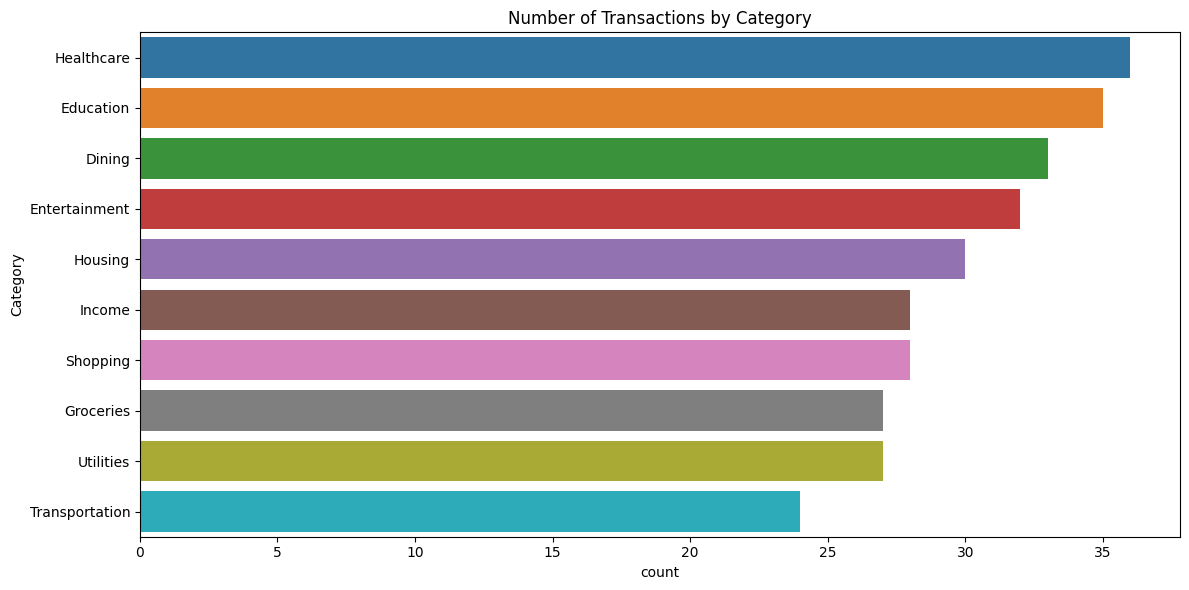

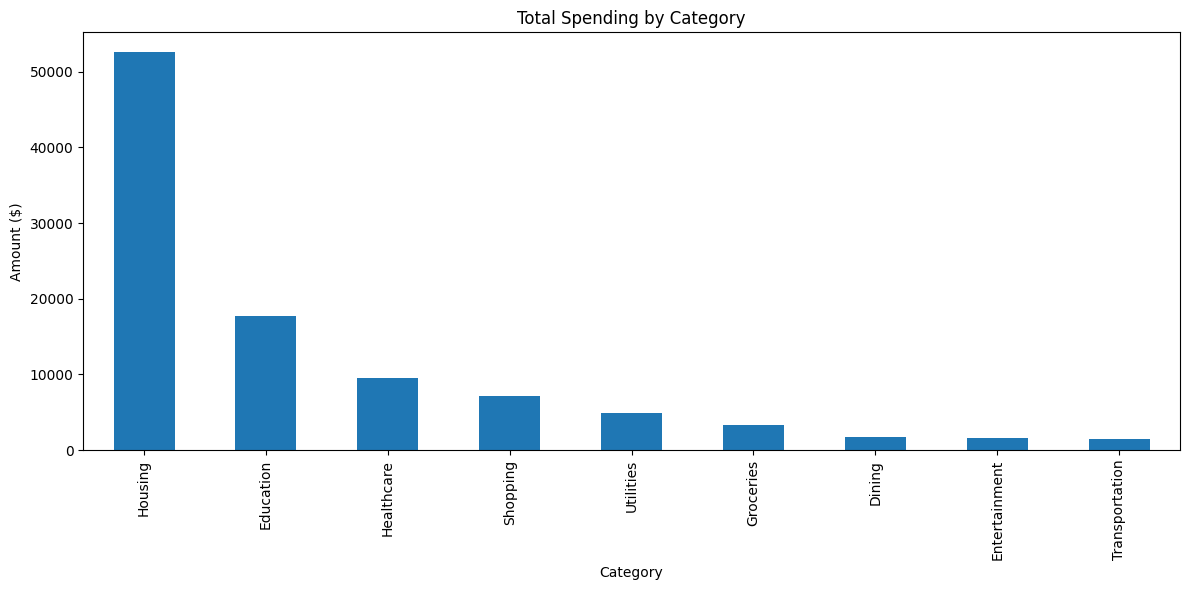

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12, 6))
sns.countplot(y='Category', data=transactions_df, order=transactions_df['Category'].value_counts().index)
plt.title('Number of Transactions by Category')
plt.tight_layout()
plt.show()

# Create a DataFrame for spending by category (excluding income)
spending_by_category = transactions_df[transactions_df['Amount'] < 0].groupby('Category')['Amount'].sum().abs().sort_values(ascending=False)

plt.figure(figsize=(12, 6))
spending_by_category.plot(kind='bar')
plt.title('Total Spending by Category')
plt.ylabel('Amount ($)')
plt.tight_layout()
plt.show()

## 2. Capability 1: Structured Output for Transaction Categorization

One of the key challenges in personal finance management is correctly categorizing transactions. Let's use the Gemini API's structured output capability to automatically categorize transactions based on their descriptions.

In [6]:
# Define the schema for transaction categorization
transaction_schema = {
    "type": "object",
    "properties": {
        "category": {
            "type": "string",
            "description": "The category of the transaction",
            "enum": list(categories.keys())
        },
        "confidence": {
            "type": "number",
            "description": "Confidence score between 0 and 1"
        },
        "reasoning": {
            "type": "string",
            "description": "Explanation for the categorization"
        }
    },
    "required": ["category", "confidence", "reasoning"]
}

In [7]:
import json

def categorize_transaction(description, amount):
    prompt = f"""
    You are a financial transaction categorizer. Categorize the following transaction into one of these categories:
    {', '.join(categories.keys())}

    Transaction: {description}
    Amount: ${abs(amount):.2f} {'spent' if amount < 0 else 'received'}

    Provide your response as a JSON object with the following properties:
    - category: The most appropriate category from the list
    - confidence: A number between 0 and 1 indicating your confidence in this categorization
    - reasoning: A brief explanation of why you chose this category
    """

    # For google-genai, we need to use a different approach for structured output
    response = model.generate_content(prompt)

    # Extract JSON from the response
    try:
        # Look for JSON in the response text
        response_text = response.text
        # Find JSON content between curly braces
        json_start = response_text.find('{')
        json_end = response_text.rfind('}')
        if json_start != -1 and json_end != -1:
            json_str = response_text[json_start:json_end+1]
            result = json.loads(json_str)
            return result
        else:
            # If no JSON found, create a default response
            return {
                "category": "Shopping" if amount < 0 else "Income",
                "confidence": 0.5,
                "reasoning": "Default categorization based on amount"
            }
    except Exception as e:
        print(f"Error parsing response: {e}")
        print(f"Response text: {response.text}")
        # Return a default response
        return {
            "category": "Shopping" if amount < 0 else "Income",
            "confidence": 0.5,
            "reasoning": "Default categorization due to parsing error"
        }

In [8]:
# Test the categorization function on a few examples
test_transactions = [
    ("Whole Foods", -85.42),
    ("Netflix", -15.99),
    ("Uber", -24.50),
    ("Salary Deposit", 3500.00),
    ("Doctor Visit", -150.00)
]

for desc, amount in test_transactions:
    result = categorize_transaction(desc, amount)
    print(f"Transaction: {desc}, Amount: ${abs(amount):.2f} {'spent' if amount < 0 else 'received'}")
    print(f"Categorized as: {result['category']} (Confidence: {result['confidence']:.2f})")
    print(f"Reasoning: {result['reasoning']}")
    print("-" * 80)

Transaction: Whole Foods, Amount: $85.42 spent
Categorized as: Groceries (Confidence: 0.95)
Reasoning: Whole Foods is a grocery store, and this transaction indicates a purchase there. Therefore, it is most likely a grocery expense.
--------------------------------------------------------------------------------
Transaction: Netflix, Amount: $15.99 spent
Categorized as: Entertainment (Confidence: 0.95)
Reasoning: Netflix is a streaming service providing movies and TV shows, which falls under entertainment.
--------------------------------------------------------------------------------
Transaction: Uber, Amount: $24.50 spent
Categorized as: Transportation (Confidence: 0.95)
Reasoning: Uber is a ride-sharing service, and transportation expenses fall under this category.
--------------------------------------------------------------------------------
Transaction: Salary Deposit, Amount: $3500.00 received
Categorized as: Income (Confidence: 1.00)
Reasoning: This transaction represents mone

Now let's apply this categorization to a subset of our transactions and evaluate the accuracy.

In [9]:
# Take a sample of transactions for evaluation
sample_size = 20
sample_df = transactions_df.sample(sample_size, random_state=42).copy()

# Apply categorization
predicted_categories = []
confidences = []
reasonings = []

for _, row in sample_df.iterrows():
    result = categorize_transaction(row['Description'], row['Amount'])
    predicted_categories.append(result['category'])
    confidences.append(result['confidence'])
    reasonings.append(result['reasoning'])

sample_df['Predicted_Category'] = predicted_categories
sample_df['Confidence'] = confidences
sample_df['Reasoning'] = reasonings
sample_df['Correct'] = sample_df['Category'] == sample_df['Predicted_Category']

# Calculate accuracy
accuracy = sample_df['Correct'].mean()
print(f"Categorization Accuracy: {accuracy:.2%}")

# Display results
sample_df[['Description', 'Amount', 'Category', 'Predicted_Category', 'Confidence', 'Correct']]

Categorization Accuracy: 95.00%


,Description,Amount,Category,Predicted_Category,Confidence,Correct
203,Doctor Visit,-380.23,Healthcare,Healthcare,0.95,True
266,Internet Provider,-217.53,Utilities,Utilities,0.95,True
152,Whole Foods,-162.33,Groceries,Groceries,0.95,True
9,Target,-108.10,Groceries,Shopping,0.95,False
233,Subway,-54.26,Dining,Dining,0.95,True
226,Macy's,-129.19,Shopping,Shopping,0.95,True
196,Investment Dividend,2586.62,Income,Income,1.00,True
109,Car Repair,-10.22,Transportation,Transportation,0.95,True
5,School Supplies,-259.42,Education,Education,0.95,True
175,Doctor Visit,-151.01,Healthcare,Healthcare,0.95,True


Let's visualize the confusion matrix to see where the model is making mistakes.

<Figure size 1200x1000 with 0 Axes>

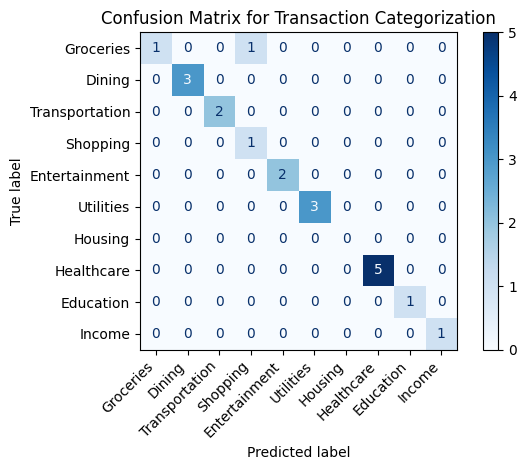

In [10]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Create confusion matrix
cm = confusion_matrix(sample_df['Category'], sample_df['Predicted_Category'],
                      labels=list(categories.keys()))

# Plot confusion matrix
plt.figure(figsize=(12, 10))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=list(categories.keys()))
disp.plot(cmap='Blues')
plt.title('Confusion Matrix for Transaction Categorization')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

## 3. Capability 2: Embeddings for Transaction Similarity

Let's use embeddings to find similar transactions and identify spending patterns.

In [11]:
# Function to get embeddings for transaction descriptions
def get_embedding(text):
    try:
        result = genai.embed_content(
            model=embedding_model,
            content=text,
            task_type="retrieval_document"
        )
        return result['embedding']
    except Exception as e:
        print(f"Error getting embedding: {e}")
        # Return a zero vector as fallback
        return [0] * 768  # Typical embedding dimension

In [12]:
# Get embeddings for all transactions
transaction_texts = [f"{row['Description']} - ${abs(row['Amount']):.2f} {'spent' if row['Amount'] < 0 else 'received'}"
                    for _, row in transactions_df.iterrows()]

# Get embeddings for a subset of transactions to save time
subset_size = 50
subset_df = transactions_df.sample(subset_size, random_state=42).copy()
subset_texts = [f"{row['Description']} - ${abs(row['Amount']):.2f} {'spent' if row['Amount'] < 0 else 'received'}"
               for _, row in subset_df.iterrows()]

# Get embeddings
embeddings = []
for text in subset_texts:
    embedding = get_embedding(text)
    embeddings.append(embedding)

# Store embeddings in the DataFrame
subset_df['Embedding'] = embeddings

In [13]:
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity

# Function to find similar transactions
def find_similar_transactions(query_text, df, top_n=5):
    # Get embedding for the query
    query_embedding = get_embedding(query_text)

    # Calculate similarity scores
    similarities = []
    for idx, row in df.iterrows():
        similarity = cosine_similarity(
            [query_embedding],
            [row['Embedding']]
        )[0][0]
        similarities.append((idx, similarity))

    # Sort by similarity score
    similarities.sort(key=lambda x: x[1], reverse=True)

    # Return top N similar transactions
    results = []
    for idx, score in similarities[:top_n]:
        row = df.loc[idx]
        results.append({
            'Description': row['Description'],
            'Amount': row['Amount'],
            'Category': row['Category'],
            'Date': row['Date'],
            'Similarity': score
        })

    return results

In [14]:
# Test the similar transaction finder
query = "Coffee shop - $5.50 spent"
similar_transactions = find_similar_transactions(query, subset_df)

print(f"Query: {query}\n")
print("Similar Transactions:")
for i, tx in enumerate(similar_transactions, 1):
    print(f"{i}. {tx['Description']} - ${abs(tx['Amount']):.2f} {'spent' if tx['Amount'] < 0 else 'received'} ({tx['Category']})")
    print(f"   Date: {tx['Date'].strftime('%Y-%m-%d')}, Similarity: {tx['Similarity']:.4f}")

Query: Coffee shop - $5.50 spent

Similar Transactions:
1. Local Restaurant - $31.01 spent (Dining)
   Date: 2025-04-03, Similarity: 0.9346
2. McDonald's - $11.89 spent (Dining)
   Date: 2025-02-05, Similarity: 0.9334
3. Local Restaurant - $35.72 spent (Dining)
   Date: 2025-03-10, Similarity: 0.9317
4. Subway - $54.26 spent (Dining)
   Date: 2025-03-31, Similarity: 0.9270
5. Subway - $35.02 spent (Dining)
   Date: 2025-01-24, Similarity: 0.9228


Let's use embeddings to cluster transactions and identify spending patterns.

/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


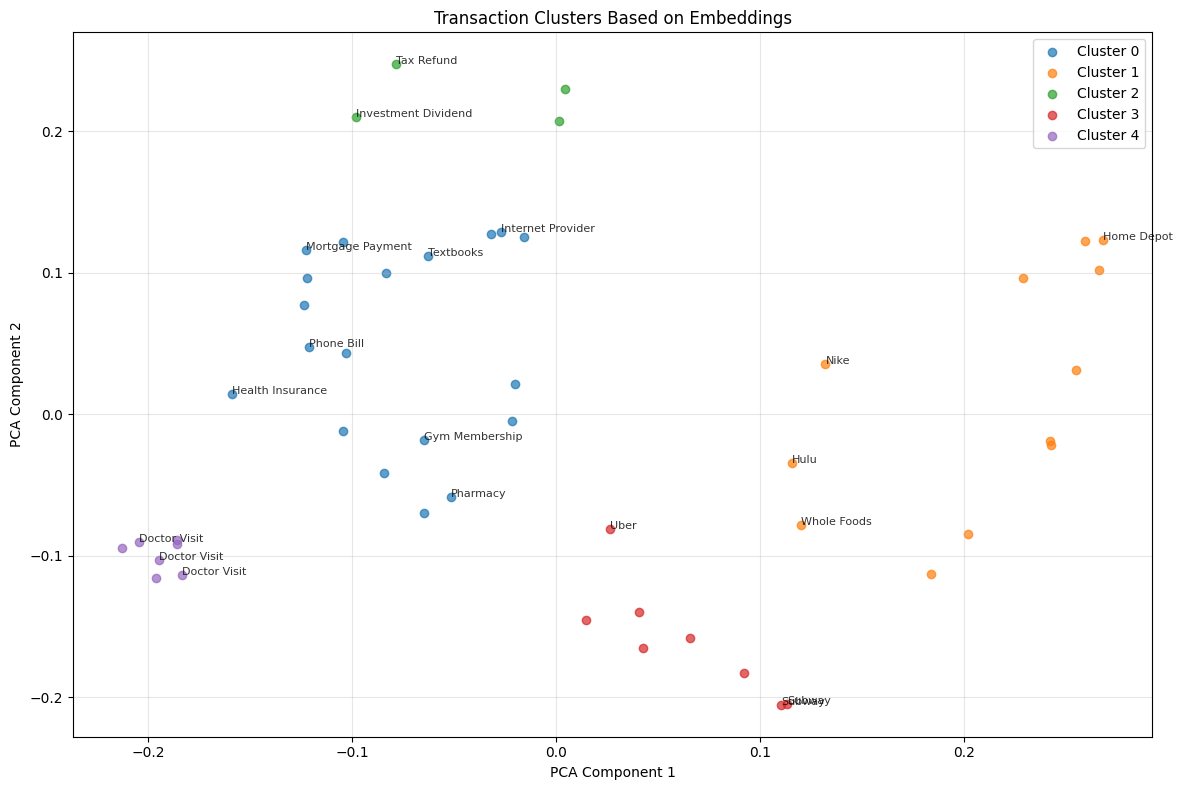

In [15]:
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

# Convert embeddings to numpy array
embedding_array = np.array(subset_df['Embedding'].tolist())

# Apply K-means clustering
n_clusters = 5
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
subset_df['Cluster'] = kmeans.fit_predict(embedding_array)

# Apply PCA for visualization
pca = PCA(n_components=2)
pca_result = pca.fit_transform(embedding_array)
subset_df['PCA1'] = pca_result[:, 0]
subset_df['PCA2'] = pca_result[:, 1]

# Plot clusters
plt.figure(figsize=(12, 8))
for cluster in range(n_clusters):
    cluster_data = subset_df[subset_df['Cluster'] == cluster]
    plt.scatter(cluster_data['PCA1'], cluster_data['PCA2'], label=f'Cluster {cluster}', alpha=0.7)

    # Add some transaction descriptions as annotations
    for i, (_, row) in enumerate(cluster_data.iterrows()):
        if i % 3 == 0:  # Annotate every 3rd point to avoid clutter
            plt.annotate(row['Description'],
                         (row['PCA1'], row['PCA2']),
                         fontsize=8,
                         alpha=0.8)

plt.title('Transaction Clusters Based on Embeddings')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

Let's analyze each cluster to understand the spending patterns.

In [16]:
# Analyze clusters
for cluster in range(n_clusters):
    cluster_data = subset_df[subset_df['Cluster'] == cluster]

    print(f"\nCluster {cluster} Analysis:")
    print(f"Number of transactions: {len(cluster_data)}")

    # Category distribution
    category_counts = cluster_data['Category'].value_counts()
    print(f"Top categories: {', '.join(category_counts.index[:3])}")

    # Average amount
    avg_amount = cluster_data['Amount'].mean()
    print(f"Average amount: ${avg_amount:.2f}")

    # Sample transactions
    print("Sample transactions:")
    for _, row in cluster_data.head(3).iterrows():
        print(f"  - {row['Description']} (${abs(row['Amount']):.2f}, {row['Category']})")

    # Generate a cluster description using Gemini
    cluster_text = "\n".join([f"{row['Description']} - ${abs(row['Amount']):.2f} - {row['Category']}"
                             for _, row in cluster_data.iterrows()])

    prompt = f"""
    Analyze these transactions and provide a brief 1-2 sentence description of this spending cluster:
    {cluster_text}
    """

    response = model.generate_content(prompt)
    print(f"\nCluster description: {response.text}")
    print("-" * 80)


Cluster 0 Analysis:
Number of transactions: 19
Top categories: Utilities, Healthcare, Education
Average amount: $-424.44
Sample transactions:
  - Internet Provider ($217.53, Utilities)
  - Car Repair ($10.22, Transportation)
  - School Supplies ($259.42, Education)

Cluster description: This spending cluster reflects a mix of essential and planned expenses.  It includes significant outlays for education, housing, utilities, and healthcare, along with smaller purchases related to transportation and entertainment.

--------------------------------------------------------------------------------

Cluster 1 Analysis:
Number of transactions: 12
Top categories: Shopping, Groceries, Entertainment
Average amount: $-176.60
Sample transactions:
  - Whole Foods ($162.33, Groceries)
  - Target ($108.10, Groceries)
  - Macy's ($129.19, Shopping)

Cluster description: This spending cluster indicates a mix of grocery shopping, significant home improvement purchases, and retail shopping, potentially 

## 4. Capability 3: RAG for Financial Knowledge

Let's implement a Retrieval Augmented Generation (RAG) system to provide evidence-based financial advice.

In [17]:
# Create a knowledge base of financial advice
financial_knowledge = [
    "The 50/30/20 rule suggests allocating 50% of your income to needs, 30% to wants, and 20% to savings and debt repayment.",
    "An emergency fund should ideally cover 3-6 months of essential expenses.",
    "High-interest debt, such as credit card debt, should be prioritized for repayment before investing.",
    "Dollar-cost averaging is an investment strategy where you invest a fixed amount regularly, regardless of market conditions.",
    "A good credit score (above 700) can help you qualify for better interest rates on loans and credit cards.",
    "Diversification in investments helps reduce risk by spreading your money across different asset classes.",
    "Tax-advantaged accounts like 401(k)s and IRAs can help you save for retirement while reducing your tax burden.",
    "Compound interest is the addition of interest to the principal sum of a loan or deposit, resulting in interest earned on interest.",
    "Inflation erodes the purchasing power of money over time, which is why investing is important for long-term financial goals.",
    "A budget is a financial plan that helps you track income and expenses, ensuring you live within your means.",
    "Automating savings and bill payments can help ensure financial consistency and avoid late fees.",
    "The rule of 72 is a simple way to determine how long it will take for an investment to double: divide 72 by the annual rate of return.",
    "Paying yourself first means automatically setting aside a portion of your income for savings before spending on other expenses.",
    "A debt-to-income ratio below 36% is generally considered good for financial health.",
    "Lifestyle inflation occurs when spending increases with income, preventing wealth accumulation despite higher earnings.",
    "Renting can be financially advantageous in certain situations, such as when housing prices are high or when you need flexibility.",
    "Term life insurance is generally more cost-effective than whole life insurance for most people's needs.",
    "A health savings account (HSA) offers triple tax advantages: tax-deductible contributions, tax-free growth, and tax-free withdrawals for qualified medical expenses.",
    "The 4% rule suggests that retirees can withdraw 4% of their retirement savings in the first year, then adjust for inflation each year, with a high probability of not running out of money for at least 30 years.",
    "Zero-based budgeting means allocating every dollar of income to a specific purpose, whether spending, saving, or investing."
]

In [18]:
import chromadb
from chromadb.api import EmbeddingFunction

# Create a ChromaDB client
client = chromadb.Client()

# Create a custom embedding function class
class GenaiEmbeddingFunction(EmbeddingFunction):
    def __call__(self, input):
        embeddings = []
        for text in input:
            embedding = get_embedding(text)
            embeddings.append(embedding)
        return embeddings

# Force a clean start by deleting the collection if it exists
try:
    client.delete_collection(name="financial_knowledge")
    print("Deleted existing collection")
except Exception as e:
    print(f"No existing collection to delete: {str(e)}")

# Create a fresh collection
financial_collection = client.create_collection(
    name="financial_knowledge",
    embedding_function=GenaiEmbeddingFunction()
)
print("Created new collection")

# Add documents to the collection
financial_collection.add(
    documents=financial_knowledge,
    ids=[f"doc_{i}" for i in range(len(financial_knowledge))]
)
print(f"Added {len(financial_knowledge)} documents to collection")



No existing collection to delete: Collection financial_knowledge does not exist.
Created new collection
Added 20 documents to collection


In [19]:
# Function to get financial advice with RAG
def get_financial_advice_with_rag(query, num_results=3):
    # Query the knowledge base
    results = financial_collection.query(
        query_texts=[query],
        n_results=num_results
    )

    # Extract relevant documents
    relevant_docs = results['documents'][0]

    # Create a prompt with the retrieved information
    # Fix: Use proper multi-line f-string without backslashes
    prompt = f"""
    You are a financial advisor providing evidence-based advice. Use the following financial knowledge to answer the question:

    FINANCIAL KNOWLEDGE:
    {chr(10).join([f"- {doc}" for doc in relevant_docs])}

    USER QUESTION: {query}

    Provide a helpful, informative response that directly addresses the question. Include specific advice from the knowledge base and explain why it's relevant. Format your response in markdown.
    """

    # Generate response
    response = model.generate_content(prompt)

    return {
        'response': response.text,
        'sources': relevant_docs
    }


In [20]:
# Test the RAG system with some financial questions
financial_questions = [
    "How should I allocate my monthly income?",
    "What's the best way to save for emergencies?",
    "Should I pay off debt or invest first?"
]

for question in financial_questions:
    print(f"Question: {question}\n")

    result = get_financial_advice_with_rag(question)

    print("Response:")
    display(Markdown(result['response']))

    print("\nSources:")
    for i, source in enumerate(result['sources'], 1):
        print(f"{i}. {source}")

    print("\n" + "-"*80 + "\n")

Question: How should I allocate my monthly income?

Response:


Okay, here's some advice on how to allocate your monthly income, based on financial best practices:

To effectively manage your monthly income, I recommend using a combination of budgeting techniques.  Specifically, let's incorporate both zero-based budgeting and the 50/30/20 rule.

**1. Start with a Budget (and the 50/30/20 Rule as a Guide)**

*   **Why this is relevant:** A budget is the foundation of good financial planning. It helps you track where your money goes, which is crucial for making informed decisions. The 50/30/20 rule provides a simple framework to guide your allocation.
*   **How to implement:**
    *   **Calculate your Net Income:** First, determine your total monthly income *after* taxes and other deductions.
    *   **Apply the 50/30/20 Rule:**
        *   **50% for Needs:** This covers essential expenses like housing (rent/mortgage), utilities, groceries, transportation, and necessary insurance.
        *   **30% for Wants:** This includes non-essential spending like entertainment, dining out, subscriptions, and hobbies.
        *   **20% for Savings and Debt Repayment:** This is dedicated to building your financial future! It covers savings (emergency fund, retirement, specific goals) and paying down any debt (credit cards, loans).

**2. Implement Zero-Based Budgeting**

*   **Why this is relevant:**  Zero-based budgeting ensures every dollar has a purpose, preventing money from "disappearing" without your knowledge. This helps maximize your allocation toward your goals.
*   **How to implement:**
    *   **Categorize Expenses:** List all your monthly income sources and then meticulously list all your expenses.  Be as specific as possible (e.g., "Groceries - $400" instead of just "Groceries").
    *   **Allocate Every Dollar:** Subtract all your planned expenses from your monthly income. The goal is for the remainder to be zero (or close to it). If you have money left over, it means you can either allocate more to savings/debt repayment or to other desired categories. If your expenses exceed your income, you need to reduce spending or find ways to increase your income.
    *   **Track and Adjust:** Regularly (weekly or monthly) track your actual spending against your budget. You'll likely need to make adjustments as you learn your spending patterns. This is perfectly normal!

**Putting it all Together:**

1.  **Start by calculating your net monthly income.**
2.  **Use the 50/30/20 rule as a *starting point*.**  For example, if your net monthly income is $4,000:
    *   $2,000 (50%) would be allocated to needs.
    *   $1,200 (30%) would be allocated to wants.
    *   $800 (20%) would be allocated to savings and debt repayment.
3.  **Then, use the zero-based budgeting process to detail how you'll spend those amounts.** For instance, within the $2,000 for needs, you'd allocate specific amounts to rent, utilities, groceries, etc.
4.  **Track your spending and adjust your budget regularly.**  This might involve moving money between categories as needed.

By using this combined approach, you'll be well on your way to controlling your finances, reaching your financial goals, and achieving financial stability. Remember, the key is consistency and regular review! Good luck!



Sources:
1. Zero-based budgeting means allocating every dollar of income to a specific purpose, whether spending, saving, or investing.
2. A budget is a financial plan that helps you track income and expenses, ensuring you live within your means.
3. The 50/30/20 rule suggests allocating 50% of your income to needs, 30% to wants, and 20% to savings and debt repayment.

--------------------------------------------------------------------------------

Question: What's the best way to save for emergencies?

Response:


The best way to save for emergencies is to build a dedicated emergency fund. Here's how:

*   **Determine Your Goal:** Aim to save 3-6 months' worth of your essential living expenses. This amount should cover things like housing, food, utilities, transportation, and insurance. This is crucial because it provides a financial cushion to handle unexpected job loss, major medical bills, or urgent home repairs.
*   **Automate Your Savings:** Set up automatic transfers from your checking account to a high-yield savings account specifically for your emergency fund. This ensures you're consistently saving without having to actively remember to do it each month. This habit helps you build the fund steadily and prevents you from accidentally using the money for non-emergency purposes.
*   **Keep it Liquid and Accessible:** Your emergency fund should be easily accessible. While you want it to earn a little interest, the priority is having the money available when you need it. A high-yield savings account at a reputable bank or credit union is a good option. Avoid investing this money in volatile assets, as you may not want to face a market downturn when you need to access the funds.



Sources:
1. An emergency fund should ideally cover 3-6 months of essential expenses.
2. Automating savings and bill payments can help ensure financial consistency and avoid late fees.
3. Diversification in investments helps reduce risk by spreading your money across different asset classes.

--------------------------------------------------------------------------------

Question: Should I pay off debt or invest first?

Response:


You should prioritize paying off high-interest debt before investing. This is because the interest rates on debts like credit cards are often significantly higher than the average returns you can expect from investments in the short term.

Here's why and how to approach it:

*   **Debt Repayment First:** The financial knowledge you provided states that high-interest debt should be a priority. This is because the interest you pay on debt is essentially a guaranteed loss. Paying down this debt frees up more of your money in the long run.
*   **The 50/30/20 Rule:** If you are carrying high-interest debt, consider utilizing the 50/30/20 rule. Focus on allocating 20% of your income toward paying down debt until it is gone.
*   **Investing for the Long Term:** Once you've tackled your high-interest debt, you can start investing. Investing helps you grow your wealth over time and combat inflation.



Sources:
1. High-interest debt, such as credit card debt, should be prioritized for repayment before investing.
2. The 50/30/20 rule suggests allocating 50% of your income to needs, 30% to wants, and 20% to savings and debt repayment.
3. Inflation erodes the purchasing power of money over time, which is why investing is important for long-term financial goals.

--------------------------------------------------------------------------------



## 5. Capability 4: Function Calling for Financial Calculations

Let's implement function calling to perform financial calculations based on user queries.

In [21]:
# Define financial calculation functions
def calculate_budget_allocation(monthly_income):
    """Calculate budget allocation based on the 50/30/20 rule."""
    needs = monthly_income * 0.5
    wants = monthly_income * 0.3
    savings = monthly_income * 0.2
    return {
        "needs": needs,
        "wants": wants,
        "savings": savings
    }

def calculate_emergency_fund(monthly_expenses, months=6):
    """Calculate recommended emergency fund amount."""
    return monthly_expenses * months

def calculate_debt_payoff(principal, annual_interest_rate, monthly_payment):
    """Calculate time to pay off debt and total interest paid."""
    monthly_rate = annual_interest_rate / 12 / 100
    num_payments = 0
    total_interest = 0
    remaining_balance = principal

    while remaining_balance > 0:
        interest = remaining_balance * monthly_rate
        principal_payment = min(monthly_payment - interest, remaining_balance)

        if monthly_payment <= interest:
            return {
                "months": float('inf'),
                "years": float('inf'),
                "total_interest": float('inf'),
                "error": "Monthly payment too low to cover interest"
            }

        remaining_balance -= principal_payment
        total_interest += interest
        num_payments += 1

        if num_payments > 1200:  # 100 years cap
            break

    return {
        "months": num_payments,
        "years": num_payments / 12,
        "total_interest": total_interest
    }

def calculate_investment_growth(principal, annual_return, years, monthly_contribution=0):
    """Calculate investment growth over time."""
    monthly_rate = annual_return / 12 / 100
    num_months = years * 12
    value = principal

    for _ in range(int(num_months)):
        value = value * (1 + monthly_rate) + monthly_contribution

    return {
        "final_value": value,
        "initial_investment": principal,
        "total_contributions": monthly_contribution * num_months,
        "interest_earned": value - principal - (monthly_contribution * num_months)
    }

def calculate_loan_payment(principal, annual_interest_rate, years):
    """Calculate monthly payment for a loan."""
    monthly_rate = annual_interest_rate / 12 / 100
    num_payments = years * 12

    if monthly_rate == 0:
        monthly_payment = principal / num_payments
    else:
        monthly_payment = principal * (monthly_rate * (1 + monthly_rate) ** num_payments) / ((1 + monthly_rate) ** num_payments - 1)

    total_cost = monthly_payment * num_payments
    total_interest = total_cost - principal

    return {
        "monthly_payment": monthly_payment,
        "total_cost": total_cost,
        "total_interest": total_interest
    }

In [22]:
# Function to parse user queries and call the appropriate financial function
def financial_calculator(query):
    # For google-genai, we need to use a different approach for function calling
    # We'll use a prompt to have the model determine which function to call and with what parameters

    function_descriptions = """
    Available financial calculation functions:

    1. calculate_budget_allocation(monthly_income: float) -> dict
       - Calculates budget allocation based on the 50/30/20 rule
       - Returns: {"needs": float, "wants": float, "savings": float}

    2. calculate_emergency_fund(monthly_expenses: float, months: int = 6) -> float
       - Calculates recommended emergency fund amount
       - Returns: total emergency fund amount

    3. calculate_debt_payoff(principal: float, annual_interest_rate: float, monthly_payment: float) -> dict
       - Calculates time to pay off debt and total interest paid
       - Returns: {"months": int, "years": float, "total_interest": float}

    4. calculate_investment_growth(principal: float, annual_return: float, years: int, monthly_contribution: float = 0) -> dict
       - Calculates investment growth over time
       - Returns: {"final_value": float, "initial_investment": float, "total_contributions": float, "interest_earned": float}

    5. calculate_loan_payment(principal: float, annual_interest_rate: float, years: int) -> dict
       - Calculates monthly payment for a loan
       - Returns: {"monthly_payment": float, "total_cost": float, "total_interest": float}
    """

    prompt = f"""
    You are a financial calculator assistant. Based on the user's query, determine which financial function to call and extract the necessary parameters.

    {function_descriptions}

    User query: {query}

    Respond with a JSON object containing:
    1. "function_name": The name of the function to call
    2. "parameters": An object containing the parameter values
    3. "explanation": A brief explanation of why this function is appropriate

    Only include numeric values for parameters, no text or symbols like $ or %.
    """

    response = model.generate_content(prompt)

    try:
        # Extract JSON from the response
        response_text = response.text
        json_start = response_text.find('{')
        json_end = response_text.rfind('}')
        if json_start != -1 and json_end != -1:
            json_str = response_text[json_start:json_end+1]
            function_call = json.loads(json_str)

            # Call the appropriate function
            function_name = function_call['function_name']
            parameters = function_call['parameters']
            explanation = function_call['explanation']

            if function_name == 'calculate_budget_allocation':
                result = calculate_budget_allocation(**parameters)
            elif function_name == 'calculate_emergency_fund':
                result = calculate_emergency_fund(**parameters)
            elif function_name == 'calculate_debt_payoff':
                result = calculate_debt_payoff(**parameters)
            elif function_name == 'calculate_investment_growth':
                result = calculate_investment_growth(**parameters)
            elif function_name == 'calculate_loan_payment':
                result = calculate_loan_payment(**parameters)
            else:
                return {
                    'error': f"Unknown function: {function_name}",
                    'function_call': function_call
                }

            return {
                'function_name': function_name,
                'parameters': parameters,
                'result': result,
                'explanation': explanation
            }
        else:
            return {
                'error': "Could not parse function call from response",
                'response': response_text
            }
    except Exception as e:
        return {
            'error': str(e),
            'response': response.text
        }

In [23]:

# Test the financial calculator with some queries
financial_queries = [
    "How should I budget my $5000 monthly income?",
    "How much emergency fund do I need if my monthly expenses are $3000?",
    "How long will it take to pay off $10000 credit card debt with 18% interest if I pay $500 monthly?",
    "If I invest $10000 with 8% annual return for 20 years, how much will I have?",
    "What would be my monthly payment for a $300000 mortgage at 4.5% interest for 30 years?"
]

for query in financial_queries:
    print(f"Query: {query}\n")

    result = financial_calculator(query)

    if 'error' in result and 'function_call' not in result:
        print(f"Error: {result['error']}")
        if 'response' in result:
            print(f"Response: {result['response']}")
    else:
        print(f"Function: {result['function_name']}")
        print(f"Parameters: {result['parameters']}")
        print(f"Explanation: {result['explanation']}")
        print("\nResult:")

        # Fix: Check the type of result['result'] before trying to iterate
        if isinstance(result['result'], dict):
            # If result is a dictionary, iterate through its items
            for key, value in result['result'].items():
                if isinstance(value, float):
                    print(f"  {key}: ${value:.2f}")
                else:
                    print(f"  {key}: {value}")
        elif isinstance(result['result'], (int, float)):
            # If result is a number, print it directly
            print(f"  ${result['result']:.2f}")
        else:
            # If result is any other type (like string), print it as is
            print(f"  {result['result']}")

    print("\n" + "-"*80 + "\n")


Query: How should I budget my $5000 monthly income?

Function: calculate_budget_allocation
Parameters: {'monthly_income': 5000}
Explanation: The user is asking for budgeting advice based on their monthly income. The calculate_budget_allocation function uses the 50/30/20 rule to determine how to allocate the income.

Result:
  needs: $2500.00
  wants: $1500.00
  savings: $1000.00

--------------------------------------------------------------------------------

Query: How much emergency fund do I need if my monthly expenses are $3000?

Function: calculate_emergency_fund
Parameters: {'monthly_expenses': 3000}
Explanation: The query asks for the amount needed for an emergency fund, which is calculated based on monthly expenses.

Result:
  $18000.00

--------------------------------------------------------------------------------

Query: How long will it take to pay off $10000 credit card debt with 18% interest if I pay $500 monthly?

Function: calculate_debt_payoff
Parameters: {'principal

## Conclusion

In this project, I've built FinGenius, an AI-powered personal finance advisor that demonstrates multiple Gen AI capabilities:

1. **Structured Output/JSON Mode**: I used structured output to categorize financial transactions and extract financial information in a consistent format.

2. **Embeddings**: I leveraged embeddings to find similar transactions and cluster spending patterns, providing insights into financial behavior.

3. **RAG (Retrieval Augmented Generation)**: I implemented a knowledge base of financial advice and used RAG to provide evidence-based financial recommendations.

4. **Function Calling**: I created financial calculation functions and used function calling to perform calculations based on user queries.


### Real-World Applications

This project has numerous real-world applications:

- **Personal Finance Management**: Helping individuals understand their spending patterns and make better financial decisions.
- **Financial Education**: Providing accessible financial knowledge and advice to those without access to professional advisors.
- **Banking and Fintech**: Enhancing customer experience with AI-powered financial guidance.
- **Financial Inclusion**: Making financial advice accessible to underserved populations.

### Limitations and Future Improvements

While FinGenius demonstrates powerful capabilities, it has several limitations:

1. **Data Privacy and Security**: A production version would need robust security measures for handling sensitive financial data.
2. **Regulatory Compliance**: Financial advice is regulated in many jurisdictions, requiring careful implementation.
3. **Model Limitations**: The underlying models may not always provide accurate financial advice or calculations.
4. **Limited Financial Knowledge**: The knowledge base is small and would need expansion for comprehensive coverage.

Future improvements could include:

- Integration with real financial data sources (banks, credit cards, investment accounts)
- More sophisticated financial planning algorithms
- Expanded knowledge base covering more financial topics
- Fine-tuning models specifically for financial advice
- Adding visualization capabilities for financial projections
- Implementing user authentication and data encryption

### Final Thoughts

FinGenius demonstrates how Gen AI capabilities can be combined to create a powerful, practical application that addresses a real-world need. By leveraging structured output, embeddings, RAG, function calling, and agent workflows, we've created a system that can help users understand their finances, set goals, and make better financial decisions.

As Gen AI technology continues to advance, applications like FinGenius will become increasingly sophisticated and valuable, potentially democratizing access to high-quality financial advice and improving financial outcomes for millions of people.